In [39]:
import pandas as pd
import xgboost as xgb
import numpy as np
from scipy.stats import uniform as sp_rand
from scipy.stats import randint as sp_randint
import random
from sklearn.metrics import r2_score, make_scorer
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold, train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import matplotlib.pyplot as plt
import pickle

## 7. Experiment

In [2]:
# data
dt_model = pd.read_csv("../../data/Mercedes_Benz_Greener_Manufacturing/data/dt_all_preprocess.csv")
params_xgb = pickle.load(open("../../data/Mercedes_Benz_Greener_Manufacturing/data/params_xgb_05.pkl", "rb"))
cols_raw = pickle.load(open("../../data/Mercedes_Benz_Greener_Manufacturing/data/cols_raw.pkl", "rb"))

In [3]:
dt_model.shape

(8418, 1575)

In [4]:
params_xgb = {'booster': 'dart',
 'colsample_bylevel': 0.9,
 'colsample_bytree': 0.7,
 'gamma': 0.6,
 'learning_rate': 0.01,
 'max_depth': 2,
 'min_child_weight': 15,
 'n_estimators': 3000,
 'reg_alpha': 0.25,
 'reg_lambda': 0.15,
 'subsample': 0.95}

{'booster': 'dart',
 'colsample_bylevel': 0.86122120778319933,
 'colsample_bytree': 0.69012513974818612,
 'gamma': 0.5813163481822099,
 'learning_rate': 0.0010647577129347552,
 'max_depth': 2,
 'min_child_weight': 10,
 'n_estimators': 2759,
 'reg_alpha': 0.67327391298067163,
 'reg_lambda': 0.56757397410099453,
 'subsample': 0.99415926878695671}

In [5]:
# r_2 for xgboost
def r_2(preds, dtrain):
    labels = dtrain.get_label()
    return 'score', r2_score(labels, preds)

# make scorer_r2
scorer_r2 = make_scorer(r2_score)

### Feature set selection

In [ ]:
# feature set select
list_cols = ["single_train", "single_test", "dup_train", "dup_test", "Is"
             , "Encode_ohe", "Encode_TargetMean", "Encode_Freq", "Encode_Binary", "Encode_Ordinal"
             , "FeatEng_OutlierMarker", "FeatEng_SumBin"
             , "DR_PCA_Raw_Bin", "DR_PCA_Encoded_Cat", "DR_PCA_FeatEng", "DR_PCA_All"
             , "DR_ICA_Raw_Bin", "DR_ICA_Encoded", "DR_ICA_FeatEng", "DR_ICA_All"
             , "DR_SVD_Raw_Bin", "DR_SVD_Encoded", "DR_SVD_FeatEng", "DR_SVD_All"
             , "DR_FA_Raw_Bin", "DR_FA_Encoded", "DR_FA_FeatEng", "DR_FA_All"
             , "DR_TSNE_Raw_Bin", "DR_TSNE_Encoded", "DR_TSNE_FeatEng", "DR_TSNE_All"
             , "DR_GRP_Raw_Bin", "DR_GRP_Encoded", "DR_GRP_FeatEng", "DR_GRP_All"
             , "DR_SRP_Raw_Bin", "DR_SRP_Encoded", "DR_SRP_FeatEng", "DR_SRP_All"]

In [ ]:
cols_core = dt_model[["ID", "y", "IsTrainTest"]].join(dt_model[cols_raw]).columns.values
dt_model_core = dt_model[cols_core]
dt_model_nonCore = dt_model.drop(cols_core, axis = 1)

In [ ]:
list_featureSelect = []
for i in range(0, 100):
    # random sample
    rand_sample = sp_randint(round(len(list_cols) / 2), len(list_cols) + 1).rvs(1)[0]
    list_cols_random = random.sample(list_cols, rand_sample)
    print("list_cols_random", list_cols_random)
    regex_cols_random = "|".join(list_cols_random)
    dt_model_nonCore_sample = dt_model_nonCore.filter(regex = regex_cols_random)
    # join with random sample
    dt_model_sample = dt_model_core.join(dt_model_nonCore_sample)
    print("shape", dt_model_sample.shape)
    # X, y, ID
    X_train_all = dt_model_sample.loc[dt_model_sample["IsTrainTest"] == "train"].drop(["y", "IsTrainTest"], axis = 1)
    X_test = dt_model_sample.loc[dt_model_sample["IsTrainTest"] == "test"].drop(["y", "IsTrainTest"], axis = 1)
    y_train_all = dt_model_sample.loc[dt_model_sample["IsTrainTest"] == "train"].y.values
    y_test = dt_model_sample.loc[dt_model_sample["IsTrainTest"] == "test"].y.values
    ID_train_all = dt_model_sample.loc[dt_model_sample["IsTrainTest"] == "train"].ID.values
    ID_test = dt_model_sample.loc[dt_model_sample["IsTrainTest"] == "test"].ID.values
    # xgbDmatrix
    dmx_train_all = xgb.DMatrix(X_train_all, label = y_train_all)
    dmx_test = xgb.DMatrix(X_test)
    # base_score
    params_xgb["base_score"] = np.mean(y_train_all)
    # cv
    cv_xgb = xgb.cv(params_xgb, dmx_train_all
                    , num_boost_round = 2000
                    , nfold = 10
                    , feval = r_2, maximize = True, early_stopping_rounds = 50
                    , show_stdv = True, verbose_eval = 50)
    # record
    score = cv_xgb["test-score-mean"][cv_xgb.shape[0] - 1]
    sd = cv_xgb["test-score-std"][cv_xgb.shape[0] - 1]
    dict_featureSelect = {"score": score
                         , "sd": sd
                         , "nonCoreFeatures": list_cols_random}
    list_featureSelect.append(dict_featureSelect)

In [ ]:
score_max = np.max([x["score"] for x in list_featureSelect])
cols_nonCore_max = [x["nonCoreFeatures"] for x in list_featureSelect if x["score"] == score_max][0]

In [ ]:
regex_cols_nonCore_max = "|".join(cols_nonCore_max)

### Produce model

In [ ]:
# dt_model_features = dt_model_core.join(dt_model_nonCore.filter(regex = regex_cols_nonCore_max))
# dt_model_features.shape

In [ ]:
# remove ohe and targetMean
# dt_model_features = dt_model.drop(dt_model.filter(regex = "Encode_ohe|Encode_Freq|Encode_Binary|FeatEng_SumBin|single_train|dup_train").columns, axis = 1)
# dt_model_features.shape

In [6]:
# remove ohe
dt_model_features = dt_model.drop(dt_model.filter(regex = "Encode_ohe").columns, axis = 1)
dt_model_features.shape

(8418, 1364)

In [7]:
# X, y, ID
X_train_all = dt_model_features.loc[dt_model_features["IsTrainTest"] == "train"].drop(["y", "IsTrainTest"], axis = 1)
X_test = dt_model_features.loc[dt_model_features["IsTrainTest"] == "test"].drop(["y", "IsTrainTest"], axis = 1)
y_train_all = dt_model_features.loc[dt_model_features["IsTrainTest"] == "train"].y.values
y_test = dt_model_features.loc[dt_model_features["IsTrainTest"] == "test"].y.values
ID_train_all = dt_model_features.loc[dt_model_features["IsTrainTest"] == "train"].ID.values
ID_test = dt_model_features.loc[dt_model_features["IsTrainTest"] == "test"].ID.values

In [8]:
X_train_all.shape

(4209, 1362)

In [9]:
# xgbDmatrix
dmx_train_all = xgb.DMatrix(X_train_all, label = y_train_all)
dmx_test = xgb.DMatrix(X_test)

In [40]:
params_xgb = {'booster': 'dart',
 'colsample_bylevel': 0.9,
 'colsample_bytree': 0.7,
 'gamma': 0.6,
 'learning_rate': 0.0025,
 'max_depth': 2,
 'min_child_weight': 15,
 'n_estimators': 3000,
 'reg_alpha': 0.25,
 'reg_lambda': 0.15,
 'subsample': 0.95}

In [41]:
params_xgb["base_score"] = np.mean(y_train_all)

In [42]:
k = 10
# bin
bin_y = pd.qcut(y_train_all, k, labels = [i for i in range(1, k + 1)]).astype("int64")
# stratified kfold
skf = StratifiedKFold(n_splits = k, shuffle = True, random_state = 888)

score_skf_valid = 0
score_skf = 0
preds_skf_test = []
for i, (ind_train, ind_valid) in enumerate(skf.split(X_train_all, bin_y)):
    # X, y
    X_train, X_valid = X_train_all.iloc[ind_train], X_train_all.iloc[ind_valid]
    y_train, y_valid = y_train_all[ind_train], y_train_all[ind_valid]
    # xgb.DMatrix
    dmx_train_all = xgb.DMatrix(X_train, label = y_train)
    dmx_valid_all = xgb.DMatrix(X_valid, label = y_valid)
    ls_watch =  [(dmx_train_all, 'train'), (dmx_valid_all, 'eval')]
    
    model_xgb = xgb.train(params_xgb, dmx_train_all, evals = ls_watch
                          , num_boost_round = 5000
                          , feval = r_2, maximize = True, early_stopping_rounds = 50
                          , verbose_eval = 50
                         )
    
    preds_valid = model_xgb.predict(dmx_valid_all)
    score_skf_valid = r2_score(y_valid, preds_valid)
    print('Fold %d: Score %f'%(i, score_skf_valid))

    score_skf += score_skf_valid

score_skf /= k
print('=====================')

print( 'Final Score %f'%score_skf)

print('=====================')

[0]	train-rmse:12.6479	eval-rmse:12.7666	train-score:0.002839	eval-score:0.002657
Multiple eval metrics have been passed: 'eval-score' will be used for early stopping.

Will train until eval-score hasn't improved in 50 rounds.
[50]	train-rmse:11.8265	eval-rmse:11.9904	train-score:0.128153	eval-score:0.120249
[100]	train-rmse:11.1449	eval-rmse:11.352	train-score:0.225755	eval-score:0.211436
[150]	train-rmse:10.5843	eval-rmse:10.8319	train-score:0.301689	eval-score:0.282039
[200]	train-rmse:10.1252	eval-rmse:10.4109	train-score:0.360949	eval-score:0.336757
[250]	train-rmse:9.753	eval-rmse:10.0734	train-score:0.407069	eval-score:0.37907
[300]	train-rmse:9.4523	eval-rmse:9.80417	train-score:0.443068	eval-score:0.411813
[350]	train-rmse:9.21119	eval-rmse:9.5908	train-score:0.471118	eval-score:0.437137
[400]	train-rmse:9.0188	eval-rmse:9.42308	train-score:0.49298	eval-score:0.456651
[450]	train-rmse:8.86609	eval-rmse:9.29187	train-score:0.510005	eval-score:0.471676
[500]	train-rmse:8.7445	ev

[1000]	train-rmse:8.39334	eval-rmse:7.66878	train-score:0.562264	eval-score:0.629549
[1050]	train-rmse:8.37165	eval-rmse:7.65305	train-score:0.564523	eval-score:0.631068
[1100]	train-rmse:8.35198	eval-rmse:7.63992	train-score:0.566567	eval-score:0.632333
[1150]	train-rmse:8.3335	eval-rmse:7.62804	train-score:0.568483	eval-score:0.633475
[1200]	train-rmse:8.31656	eval-rmse:7.61701	train-score:0.570235	eval-score:0.634534
[1250]	train-rmse:8.30048	eval-rmse:7.60744	train-score:0.571896	eval-score:0.635452
[1300]	train-rmse:8.28521	eval-rmse:7.59951	train-score:0.57347	eval-score:0.636212
[1350]	train-rmse:8.27053	eval-rmse:7.59364	train-score:0.57498	eval-score:0.636773
[1400]	train-rmse:8.25654	eval-rmse:7.58733	train-score:0.576416	eval-score:0.637377
[1450]	train-rmse:8.24226	eval-rmse:7.58322	train-score:0.57788	eval-score:0.63777
[1500]	train-rmse:8.22928	eval-rmse:7.57817	train-score:0.579209	eval-score:0.638252
[1550]	train-rmse:8.21789	eval-rmse:7.57257	train-score:0.580373	eval-

[1450]	train-rmse:8.15389	eval-rmse:8.27858	train-score:0.587947	eval-score:0.558111
[1500]	train-rmse:8.14099	eval-rmse:8.27672	train-score:0.58925	eval-score:0.558309
[1550]	train-rmse:8.12878	eval-rmse:8.27575	train-score:0.590481	eval-score:0.558413
Stopping. Best iteration:
[1526]	train-rmse:8.13465	eval-rmse:8.2756	train-score:0.589889	eval-score:0.558429

Fold 4: Score 0.558363
[0]	train-rmse:12.4423	eval-rmse:14.4752	train-score:0.002949	eval-score:0.001924
Multiple eval metrics have been passed: 'eval-score' will be used for early stopping.

Will train until eval-score hasn't improved in 50 rounds.
[50]	train-rmse:11.6046	eval-rmse:13.7928	train-score:0.132689	eval-score:0.093809
[100]	train-rmse:10.9076	eval-rmse:13.2428	train-score:0.233752	eval-score:0.164636
[150]	train-rmse:10.3315	eval-rmse:12.803	train-score:0.31255	eval-score:0.219203
[200]	train-rmse:9.85916	eval-rmse:12.4536	train-score:0.373973	eval-score:0.261231
[250]	train-rmse:9.47506	eval-rmse:12.1796	train-sco

[500]	train-rmse:8.86158	eval-rmse:8.12212	train-score:0.517033	eval-score:0.5415
[550]	train-rmse:8.76361	eval-rmse:8.03774	train-score:0.527654	eval-score:0.550977
[600]	train-rmse:8.68434	eval-rmse:7.97197	train-score:0.53616	eval-score:0.558296
[650]	train-rmse:8.61848	eval-rmse:7.92273	train-score:0.543169	eval-score:0.563736
[700]	train-rmse:8.56345	eval-rmse:7.88287	train-score:0.548983	eval-score:0.568114
[750]	train-rmse:8.51654	eval-rmse:7.85245	train-score:0.553911	eval-score:0.571442
[800]	train-rmse:8.47649	eval-rmse:7.82849	train-score:0.558096	eval-score:0.574053
[850]	train-rmse:8.44199	eval-rmse:7.81069	train-score:0.561687	eval-score:0.575988
[900]	train-rmse:8.41205	eval-rmse:7.79564	train-score:0.56479	eval-score:0.57762
[950]	train-rmse:8.38498	eval-rmse:7.78474	train-score:0.567587	eval-score:0.5788
[1000]	train-rmse:8.36098	eval-rmse:7.77653	train-score:0.570059	eval-score:0.579688
[1050]	train-rmse:8.33903	eval-rmse:7.76956	train-score:0.572313	eval-score:0.5804

[1550]	train-rmse:8.14185	eval-rmse:8.24606	train-score:0.583678	eval-score:0.609701
[1600]	train-rmse:8.13035	eval-rmse:8.24439	train-score:0.584854	eval-score:0.609859
[1650]	train-rmse:8.1198	eval-rmse:8.24185	train-score:0.58593	eval-score:0.610099
[1700]	train-rmse:8.1094	eval-rmse:8.23906	train-score:0.58699	eval-score:0.610363
[1750]	train-rmse:8.09988	eval-rmse:8.23809	train-score:0.58796	eval-score:0.610455
[1800]	train-rmse:8.09023	eval-rmse:8.23625	train-score:0.588941	eval-score:0.610629
[1850]	train-rmse:8.08087	eval-rmse:8.23424	train-score:0.589891	eval-score:0.610819
[1900]	train-rmse:8.07187	eval-rmse:8.23296	train-score:0.590804	eval-score:0.61094
[1950]	train-rmse:8.06312	eval-rmse:8.23179	train-score:0.59169	eval-score:0.611051
[2000]	train-rmse:8.05497	eval-rmse:8.23149	train-score:0.592515	eval-score:0.611079
[2050]	train-rmse:8.04711	eval-rmse:8.23086	train-score:0.59331	eval-score:0.611138
[2100]	train-rmse:8.0394	eval-rmse:8.23104	train-score:0.594089	eval-scor

In [35]:
# cv
cv_xgb = xgb.cv(params_xgb, dmx_train_all
                , num_boost_round = 5000
                , nfold = 10
                , feval = r_2, maximize = True, early_stopping_rounds = 50
                , show_stdv = True, verbose_eval = 50)

[0]	train-rmse:11.9709+0.102758	train-score:0.107556+0.00221885	test-rmse:11.9406+0.870956	test-score:0.106506+0.0154231
[50]	train-rmse:8.02038+0.164943	train-score:0.59937+0.0113859	test-rmse:8.23394+1.30232	test-score:0.574768+0.0854216


KeyboardInterrupt: 

In [27]:
cv_xgb.tail()

,test-rmse-mean,test-rmse-std,test-score-mean,test-score-std,train-rmse-mean,train-rmse-std,train-score-mean,train-score-std
2107,8.228441,1.306241,0.575222,0.086290,8.013701,0.164294,0.600038,0.011289
2108,8.228419,1.306242,0.575225,0.086290,8.013548,0.164308,0.600054,0.011290
2109,8.228388,1.306270,0.575228,0.086293,8.013395,0.164301,0.600069,0.011289
2110,8.228334,1.306291,0.575233,0.086296,8.013213,0.164325,0.600087,0.011291
2111,8.228287,1.306299,0.575238,0.086297,8.013052,0.164332,0.600103,0.011291


In [28]:
# train
model_xgb = xgb.train(params_xgb, dmx_train_all, num_boost_round = cv_xgb.shape[0])

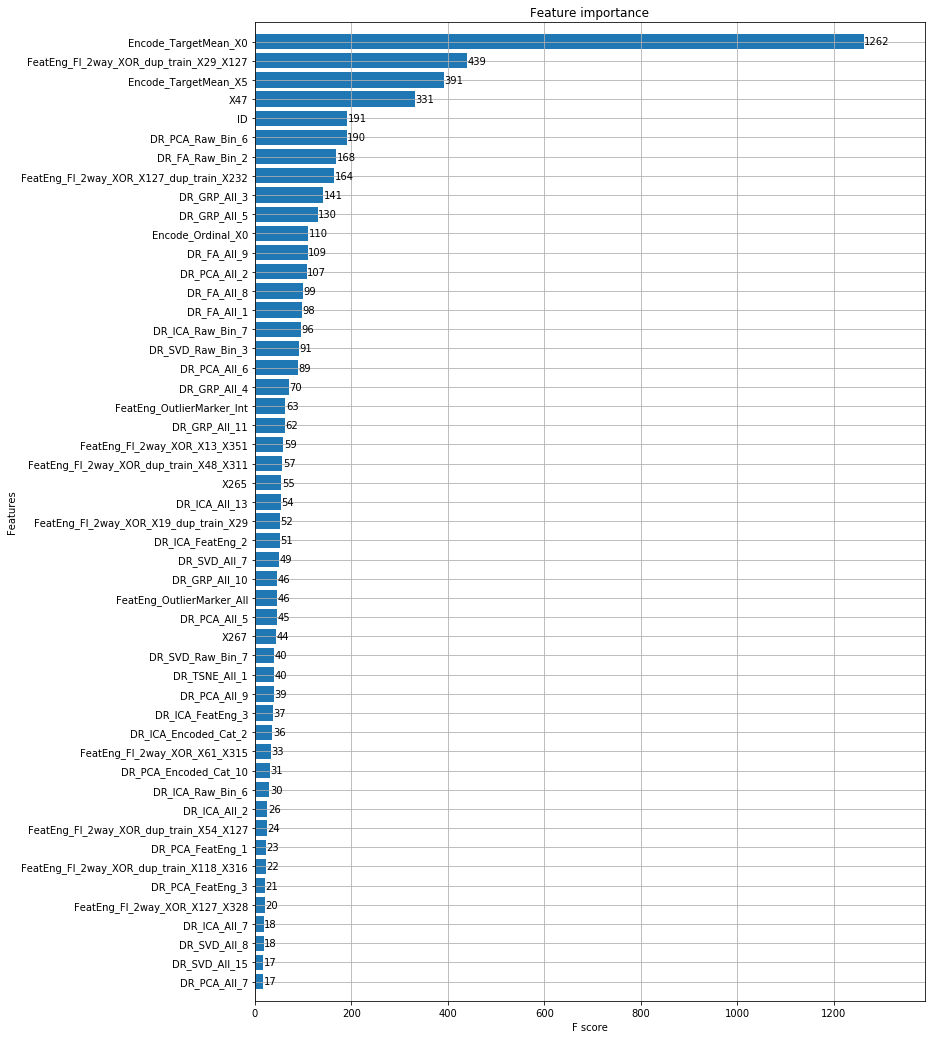

In [29]:
# importance
fig, ax = plt.subplots(figsize = (12,18))
xgb.plot_importance(model_xgb, max_num_features = 50, height = 0.8, ax = ax)
plt.show()

### Submit

In [ ]:
# predict
y_test = model_xgb.predict(dmx_test)
y_test[:10]

In [ ]:
# submit
dt_submit = pd.DataFrame({"ID": ID_test, "y": y_test})

In [ ]:
dt_submit.to_csv("../../data/Mercedes_Benz_Greener_Manufacturing/submission/15_added_FI_2way_XOR.csv", index = False)